承接 1210_00_start.py

參考: 
0. 一直不漂亮的進度條
 - 
https://stackoverflow.com/questions/7715594/how-to-reset-cursor-to-the-beginning-of-the-same-line-in-python
0. 想要關掉 jupyter 後仍運行
 - http://liuchengxu.org/pelican-blog/jupyter-notebook-tips.html
0. 未用: 
 - https://github.com/Deepayan137/K-svd

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
import time

In [3]:
class OMP_SVD: #兩個 class 合併成 sparse codeing 吧
    def __init__(self, dictionary, dataAll, letter):
        """  """
        self.D = np.matrix(dictionary.copy())
        self.X = np.matrix(dataAll.copy())
        self.L = letter
        
        self.atomNum = self.D.shape[1]
        
        #print( "長度", D_org.shape[0], "的 有", D_org.shape[1], "個")
        print( "D: shape",self.D.shape,"mean: There are", self.D.shape[1], "atoms with","length", self.D.shape[0])
        print( "X: shape",self.X.shape,"mean: There are", self.X.shape[1], "signals with","length", self.X.shape[0])
        print( "A: shape will be", (self.D.shape[1], self.X.shape[1]))
        
        return
    def SetDictionary(self, inputDictionary):
        self.D = inputDictionary.copy()
        return
    def SetAlpha(self, inputAlpha):
        self.A = inputAlpha.copy()
        return
    def Cal_OneX_alpha_OMP(self, inputX, L, boolDeubg = False):
        """ 
        算單一 signal (Xi) 的 alpha
        """
        #
        residual = inputX.copy()
        alpha = np.matrix(np.zeros((self.D.shape[1], 1))) #sparse code
        # D 轉換
        unusedD = self.D.copy()
        usedD = np.zeros_like(self.D.copy())
        for i in range(L):
            if boolDeubg:
                print("\niter:", i)
            # 算相似度
            correlated = residual.T * unusedD # np.dot(residual.T , unusedD) in matrix
            if boolDeubg:
                print("correlated", correlated)
            d_i = np.argmax( np.abs(correlated))
            
            if boolDeubg:
                print("d_i", d_i, alpha.shape)
            # 使用過不再使用
            usedD[:, d_i] = unusedD[:, d_i].copy()
            unusedD[:, d_i].fill(0)
            # 重新計算比例
            if i != 0 :#or True: # 第一次到底要不要更新呢~
                alpha = np.linalg.lstsq(usedD, inputX, rcond = None) [0]
#                alpha = np.linalg.pinv(usedD.T * usedD) * usedD.T * inputX
            else:
                alpha[d_i, :] = correlated[:, d_i]
            
            if boolDeubg:
                print("alpha", alpha, sep = "\n")
            # 殘差計算
            residual = inputX - usedD * alpha
            if boolDeubg:
                print("residual", residual, sep="\n")
        return alpha
    
    def Flow_all_OMP(self, L = None, boolDeubg = False, boolProgressShow = False):
        """  """
        alphaALL = np.matrix(np.zeros((self.D.shape[1], self.X.shape[1])))
        if L is None:
            L = self.L
        for i in range(self.X.shape[1]):
            if boolDeubg:
                print("data", i, self.X[:,i].T)
            alpha = self.Cal_OneX_alpha_OMP(self.X[:, i], L, boolDeubg = boolDeubg)
            alphaALL[:, i] = alpha.copy()
            if i % 5 == 0 and boolProgressShow:
                print("[", i, "/", self.X.shape[1], "]")
        self.A = alphaALL.copy()
        return self.A
    
    def VarifyAll(self, sparseCode, boolRound = True):
        """  """
        X_hat = self.D * np.matrix(sparseCode)
        residualALL = np.linalg.norm(self.X - X_hat, ord = 2, axis = 0)
        if boolRound:
            X_hat = np.round(X_hat, 4)
            residualALL = np.round(residualALL, 4)
        return X_hat, residualALL

    def UpdateDict_useSVD_one(self, indexOfAtom, indexOfData, boolHaoSol = False):
#        print(indexOfAtom, "=>", indexOfData, "="*10)
        if boolHaoSol:
            # 一樣結果
            t_C = self.A.copy()
            t_C[indexOfAtom, indexOfData] = 0
#            print(t_C)
            tmp_data = self.D * t_C[:, indexOfData]
            E = self.X[:, indexOfData] - tmp_data
        else:
            E = self.X[:, indexOfData] - self.D * self.A[:, indexOfData] + self.D[:, indexOfAtom] * self.A[indexOfAtom, indexOfData]
#        print("E", E)
        u, s, vh = np.linalg.svd(E) # need trans? 看E的變化應該選這個
#        v = vh.T
#        print("u:", u, "s:", s, "vh:", vh, sep = "\n")
#        print("->new d"+str(indexOfAtom), u[:, 0].T)
        self.D[:, indexOfAtom] = u[:, 0].copy()
#        print("new d"+str(indexOfAtom), u[0, :])
        newCoe = s[0] * vh[:, 0].T
#        print("new coe", newCoe)
        self.A[indexOfAtom, indexOfData] = newCoe
        return
    
    def UpdateDict_FLOW(self, boolProgressShow = False):
        usedAtomIndex, userX = np.where(self.A!=0)
#        print(usedAtomIndex)
        for indexOfAtom in range(self.D.shape[1]):
#            print("\nindexOfAtom:", indexOfAtom)#, "=> d"+str((indexOfAtom)))
            tmp = np.where(usedAtomIndex == indexOfAtom)[0]
            if tmp.shape[0] == 0:
                continue
#            print(np.where(usedAtomIndex == indexOfAtom))
#            print("=>", userX[tmp])
            self.UpdateDict_useSVD_one(indexOfAtom, userX[tmp])
            if indexOfAtom % 5 == 0 and boolProgressShow:
                print("[", indexOfAtom, "/", self.D.shape[1], "]")
        return self.D

In [4]:
#%% 重建 函數狀態
# y = noiseImg
# A = np.matrix(A)
# mu = 1 #μ
def Rebuild(y, Rij, A, D, _I, _J, _cols_patch, _rows_patch, mu = 1):
    tmp = np.zeros_like(y, dtype = np.float64)
    I = np.zeros_like(y, dtype = np.float64)
    np.fill_diagonal(I, 1)
#     I.fill(1)
    count_patch = 0
    for _i in range(0, _I, 1):
        for _j in range(0, _J, 1):
            tmp[_i:_i+_cols_patch, _j:_j+_rows_patch] += (D * A[:, count_patch]).reshape(_cols_patch, _rows_patch, order="F")
            count_patch += 1
    x = (y + mu*tmp)  / (I + mu * Rij)
    return x

### 讀取、顯示

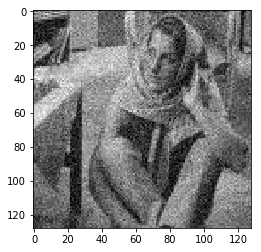

In [5]:
resultImgFolder = "TMP"
#%% 資料讀取與顯示
initailDict = np.load("dct_64_256.npy")
noiseImgName = "noise_barbara_var0.004.jpg"
originalImgName = "original_128x128_barbara.jpg"
noiseImg = cv2.imread(noiseImgName, cv2.IMREAD_GRAYSCALE)
originalImg = cv2.imread(originalImgName)
# cv2.imshow("noise image", noiseImg)
# cv2.imshow("original image", originalImg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(noiseImg, cmap = "gray")
# plt.imshow(originalImg, cmap = "gray")
plt.show()

### 切片 與 Rij 計算

In [6]:
#%% 切片 - 設置
_rows_patch, _cols_patch = 8,8
_rows, _cols = noiseImg.shape[:2]
_I = _cols - _cols_patch + 1
_J = _rows - _rows_patch + 1
X_img = np.zeros((_cols_patch * _rows_patch, \
                  _I * _J))
print(X_img.shape)

(64, 14641)


In [7]:
#%% 切片執行 與 Rij 計算
# Rij
Rij_BIG = np.zeros((_I, _J, _rows_patch*_cols_patch, _rows*_cols), dtype = np.bool) # if not bool, need 56 GB, and memory error
Rij_Progressive = np.zeros((_rows, _cols))
# 切片
count = 0 # _i*_I + _j 或這樣算
for _i in range(_I): # _I = _cols - _cols_patch
    for _j in range(_J): # _J = _rows - _rows_patch
        # 切片
        tmpImg =  noiseImg[_i:_i+_cols_patch, _j:_j+_rows_patch].flatten(order="F")
        X_img[:, count] = tmpImg.copy()
        # 計算 Rij
#         for _r in range(_cols_patch*_rows_patch):
        _r = 0
        for _i_tmp in range(_i, _i + _cols_patch):
            for _j_tmp in range(_j, _j + _rows_patch):
                Rij_BIG[_i, _j, _r, _i_tmp * _cols_patch + _j_tmp] = 1
            
                Rij_Progressive[_i_tmp, _j_tmp] += 1
                
                _r += 1
        count += 1

### 執行

In [ ]:
#%%
_startTime = time.time()
D = initailDict.copy()
# 
_count_time = 0
SP = OMP_SVD(D, X_img, 6)
#for _count_time in range(10):

D: shape (64, 256) mean: There are 256 atoms with length 64
X: shape (64, 14641) mean: There are 14641 signals with length 64
A: shape will be (256, 14641)


In [ ]:
_startTime_while = time.time()
while _count_time < 500:
    print("time:", _count_time)
    print("cal aplpha")
    A = SP.Flow_all_OMP(boolProgressShow = True)
    
    print("Rebuild")
    x = Rebuild(noiseImg, Rij_Progressive, A, D, _I, _J, _cols_patch, _rows_patch)
    cv2.imwrite( resultImgFolder + "/"+"result"+str(_count_time)+".jpg", x)
    
    print("cal dictionary")
    D = SP.UpdateDict_FLOW(boolProgressShow = True)
    
    _count_time += 1
_endTime_while = time.time()
print(_endTime - _startTime, "秒過去了")
print("Loop cost", _endTime_while - _startTime_while, "sec.")

time: 0
cal aplpha
[ 0 / 14641 ]
[ 5 / 14641 ]
[ 10 / 14641 ]
[ 15 / 14641 ]
[ 20 / 14641 ]
[ 25 / 14641 ]
[ 30 / 14641 ]
[ 35 / 14641 ]
[ 40 / 14641 ]
[ 45 / 14641 ]
[ 50 / 14641 ]
[ 55 / 14641 ]
[ 60 / 14641 ]
[ 65 / 14641 ]
[ 70 / 14641 ]
[ 75 / 14641 ]
[ 80 / 14641 ]
[ 85 / 14641 ]
[ 90 / 14641 ]
[ 95 / 14641 ]
[ 100 / 14641 ]
[ 105 / 14641 ]
[ 110 / 14641 ]
[ 115 / 14641 ]
[ 120 / 14641 ]
[ 125 / 14641 ]
[ 130 / 14641 ]
[ 135 / 14641 ]
[ 140 / 14641 ]
[ 145 / 14641 ]
[ 150 / 14641 ]
[ 155 / 14641 ]
[ 160 / 14641 ]
[ 165 / 14641 ]
[ 170 / 14641 ]
[ 175 / 14641 ]
[ 180 / 14641 ]
[ 185 / 14641 ]
[ 190 / 14641 ]
[ 195 / 14641 ]
[ 200 / 14641 ]
[ 205 / 14641 ]
[ 210 / 14641 ]
[ 215 / 14641 ]
[ 220 / 14641 ]
[ 225 / 14641 ]
[ 230 / 14641 ]
[ 235 / 14641 ]
[ 240 / 14641 ]
[ 245 / 14641 ]
[ 250 / 14641 ]
[ 255 / 14641 ]
[ 260 / 14641 ]
[ 265 / 14641 ]
[ 270 / 14641 ]
[ 275 / 14641 ]
[ 280 / 14641 ]
[ 285 / 14641 ]
[ 290 / 14641 ]
[ 295 / 14641 ]
[ 300 / 14641 ]
[ 305 / 14641 ]
[ 310 / 146

[ 2505 / 14641 ]
[ 2510 / 14641 ]
[ 2515 / 14641 ]
[ 2520 / 14641 ]
[ 2525 / 14641 ]
[ 2530 / 14641 ]
[ 2535 / 14641 ]
[ 2540 / 14641 ]
[ 2545 / 14641 ]
[ 2550 / 14641 ]
[ 2555 / 14641 ]
[ 2560 / 14641 ]
[ 2565 / 14641 ]
[ 2570 / 14641 ]
[ 2575 / 14641 ]
[ 2580 / 14641 ]
[ 2585 / 14641 ]
[ 2590 / 14641 ]
[ 2595 / 14641 ]
[ 2600 / 14641 ]
[ 2605 / 14641 ]
[ 2610 / 14641 ]
[ 2615 / 14641 ]
[ 2620 / 14641 ]
[ 2625 / 14641 ]
[ 2630 / 14641 ]
[ 2635 / 14641 ]
[ 2640 / 14641 ]
[ 2645 / 14641 ]
[ 2650 / 14641 ]
[ 2655 / 14641 ]
[ 2660 / 14641 ]
[ 2665 / 14641 ]
[ 2670 / 14641 ]
[ 2675 / 14641 ]
[ 2680 / 14641 ]
[ 2685 / 14641 ]
[ 2690 / 14641 ]
[ 2695 / 14641 ]
[ 2700 / 14641 ]
[ 2705 / 14641 ]
[ 2710 / 14641 ]
[ 2715 / 14641 ]
[ 2720 / 14641 ]
[ 2725 / 14641 ]
[ 2730 / 14641 ]
[ 2735 / 14641 ]
[ 2740 / 14641 ]
[ 2745 / 14641 ]
[ 2750 / 14641 ]
[ 2755 / 14641 ]
[ 2760 / 14641 ]
[ 2765 / 14641 ]
[ 2770 / 14641 ]
[ 2775 / 14641 ]
[ 2780 / 14641 ]
[ 2785 / 14641 ]
[ 2790 / 14641 ]
[ 2795 / 14641

[ 4935 / 14641 ]
[ 4940 / 14641 ]
[ 4945 / 14641 ]
[ 4950 / 14641 ]
[ 4955 / 14641 ]
[ 4960 / 14641 ]
[ 4965 / 14641 ]
[ 4970 / 14641 ]
[ 4975 / 14641 ]
[ 4980 / 14641 ]
[ 4985 / 14641 ]
[ 4990 / 14641 ]
[ 4995 / 14641 ]
[ 5000 / 14641 ]
[ 5005 / 14641 ]
[ 5010 / 14641 ]
[ 5015 / 14641 ]
[ 5020 / 14641 ]
[ 5025 / 14641 ]
[ 5030 / 14641 ]
[ 5035 / 14641 ]
[ 5040 / 14641 ]
[ 5045 / 14641 ]
[ 5050 / 14641 ]
[ 5055 / 14641 ]
[ 5060 / 14641 ]
[ 5065 / 14641 ]
[ 5070 / 14641 ]
[ 5075 / 14641 ]
[ 5080 / 14641 ]
[ 5085 / 14641 ]
[ 5090 / 14641 ]
[ 5095 / 14641 ]
[ 5100 / 14641 ]
[ 5105 / 14641 ]
[ 5110 / 14641 ]
[ 5115 / 14641 ]
[ 5120 / 14641 ]
[ 5125 / 14641 ]
[ 5130 / 14641 ]
[ 5135 / 14641 ]
[ 5140 / 14641 ]
[ 5145 / 14641 ]
[ 5150 / 14641 ]
[ 5155 / 14641 ]
[ 5160 / 14641 ]
[ 5165 / 14641 ]
[ 5170 / 14641 ]
[ 5175 / 14641 ]
[ 5180 / 14641 ]
[ 5185 / 14641 ]
[ 5190 / 14641 ]
[ 5195 / 14641 ]
[ 5200 / 14641 ]
[ 5205 / 14641 ]
[ 5210 / 14641 ]
[ 5215 / 14641 ]
[ 5220 / 14641 ]
[ 5225 / 14641

[ 7370 / 14641 ]
[ 7375 / 14641 ]
[ 7380 / 14641 ]
[ 7385 / 14641 ]
[ 7390 / 14641 ]
[ 7395 / 14641 ]
[ 7400 / 14641 ]
[ 7405 / 14641 ]
[ 7410 / 14641 ]
[ 7415 / 14641 ]
[ 7420 / 14641 ]
[ 7425 / 14641 ]
[ 7430 / 14641 ]
[ 7435 / 14641 ]
[ 7440 / 14641 ]
[ 7445 / 14641 ]
[ 7450 / 14641 ]
[ 7455 / 14641 ]
[ 7460 / 14641 ]
[ 7465 / 14641 ]
[ 7470 / 14641 ]
[ 7475 / 14641 ]
[ 7480 / 14641 ]
[ 7485 / 14641 ]
[ 7490 / 14641 ]
[ 7495 / 14641 ]
[ 7500 / 14641 ]
[ 7505 / 14641 ]
[ 7510 / 14641 ]
[ 7515 / 14641 ]
[ 7520 / 14641 ]
[ 7525 / 14641 ]
[ 7530 / 14641 ]
[ 7535 / 14641 ]
[ 7540 / 14641 ]
[ 7545 / 14641 ]
[ 7550 / 14641 ]
[ 7555 / 14641 ]
[ 7560 / 14641 ]
[ 7565 / 14641 ]
[ 7570 / 14641 ]
[ 7575 / 14641 ]
[ 7580 / 14641 ]
[ 7585 / 14641 ]
[ 7590 / 14641 ]
[ 7595 / 14641 ]
[ 7600 / 14641 ]
[ 7605 / 14641 ]
[ 7610 / 14641 ]
[ 7615 / 14641 ]
[ 7620 / 14641 ]
[ 7625 / 14641 ]
[ 7630 / 14641 ]
[ 7635 / 14641 ]
[ 7640 / 14641 ]
[ 7645 / 14641 ]
[ 7650 / 14641 ]
[ 7655 / 14641 ]
[ 7660 / 14641

[ 9785 / 14641 ]
[ 9790 / 14641 ]
[ 9795 / 14641 ]
[ 9800 / 14641 ]
[ 9805 / 14641 ]
[ 9810 / 14641 ]
[ 9815 / 14641 ]
[ 9820 / 14641 ]
[ 9825 / 14641 ]
[ 9830 / 14641 ]
[ 9835 / 14641 ]
[ 9840 / 14641 ]
[ 9845 / 14641 ]
[ 9850 / 14641 ]
[ 9855 / 14641 ]
[ 9860 / 14641 ]
[ 9865 / 14641 ]
[ 9870 / 14641 ]
[ 9875 / 14641 ]
[ 9880 / 14641 ]
[ 9885 / 14641 ]
[ 9890 / 14641 ]
[ 9895 / 14641 ]
[ 9900 / 14641 ]
[ 9905 / 14641 ]
[ 9910 / 14641 ]
[ 9915 / 14641 ]
[ 9920 / 14641 ]
[ 9925 / 14641 ]
[ 9930 / 14641 ]
[ 9935 / 14641 ]
[ 9940 / 14641 ]
[ 9945 / 14641 ]
[ 9950 / 14641 ]
[ 9955 / 14641 ]
[ 9960 / 14641 ]
[ 9965 / 14641 ]
[ 9970 / 14641 ]
[ 9975 / 14641 ]
[ 9980 / 14641 ]
[ 9985 / 14641 ]
[ 9990 / 14641 ]
[ 9995 / 14641 ]
[ 10000 / 14641 ]
[ 10005 / 14641 ]
[ 10010 / 14641 ]
[ 10015 / 14641 ]
[ 10020 / 14641 ]
[ 10025 / 14641 ]
[ 10030 / 14641 ]
[ 10035 / 14641 ]
[ 10040 / 14641 ]
[ 10045 / 14641 ]
[ 10050 / 14641 ]
[ 10055 / 14641 ]
[ 10060 / 14641 ]
[ 10065 / 14641 ]
[ 10070 / 14641 ]

[ 12110 / 14641 ]
[ 12115 / 14641 ]
[ 12120 / 14641 ]
[ 12125 / 14641 ]
[ 12130 / 14641 ]
[ 12135 / 14641 ]
[ 12140 / 14641 ]
[ 12145 / 14641 ]
[ 12150 / 14641 ]
[ 12155 / 14641 ]
[ 12160 / 14641 ]
[ 12165 / 14641 ]
[ 12170 / 14641 ]
[ 12175 / 14641 ]
[ 12180 / 14641 ]
[ 12185 / 14641 ]
[ 12190 / 14641 ]
[ 12195 / 14641 ]
[ 12200 / 14641 ]
[ 12205 / 14641 ]
[ 12210 / 14641 ]
[ 12215 / 14641 ]
[ 12220 / 14641 ]
[ 12225 / 14641 ]
[ 12230 / 14641 ]
[ 12235 / 14641 ]
[ 12240 / 14641 ]
[ 12245 / 14641 ]
[ 12250 / 14641 ]
[ 12255 / 14641 ]
[ 12260 / 14641 ]
[ 12265 / 14641 ]
[ 12270 / 14641 ]
[ 12275 / 14641 ]
[ 12280 / 14641 ]
[ 12285 / 14641 ]
[ 12290 / 14641 ]
[ 12295 / 14641 ]
[ 12300 / 14641 ]
[ 12305 / 14641 ]
[ 12310 / 14641 ]
[ 12315 / 14641 ]
[ 12320 / 14641 ]
[ 12325 / 14641 ]
[ 12330 / 14641 ]
[ 12335 / 14641 ]
[ 12340 / 14641 ]
[ 12345 / 14641 ]
[ 12350 / 14641 ]
[ 12355 / 14641 ]
[ 12360 / 14641 ]
[ 12365 / 14641 ]
[ 12370 / 14641 ]
[ 12375 / 14641 ]
[ 12380 / 14641 ]
[ 12385 / 

[ 14395 / 14641 ]
[ 14400 / 14641 ]
[ 14405 / 14641 ]
[ 14410 / 14641 ]
[ 14415 / 14641 ]
[ 14420 / 14641 ]
[ 14425 / 14641 ]
[ 14430 / 14641 ]
[ 14435 / 14641 ]
[ 14440 / 14641 ]
[ 14445 / 14641 ]
[ 14450 / 14641 ]
[ 14455 / 14641 ]
[ 14460 / 14641 ]
[ 14465 / 14641 ]
[ 14470 / 14641 ]
[ 14475 / 14641 ]
[ 14480 / 14641 ]
[ 14485 / 14641 ]
[ 14490 / 14641 ]
[ 14495 / 14641 ]
[ 14500 / 14641 ]
[ 14505 / 14641 ]
[ 14510 / 14641 ]
[ 14515 / 14641 ]
[ 14520 / 14641 ]
[ 14525 / 14641 ]
[ 14530 / 14641 ]
[ 14535 / 14641 ]
[ 14540 / 14641 ]
[ 14545 / 14641 ]
[ 14550 / 14641 ]
[ 14555 / 14641 ]
[ 14560 / 14641 ]
[ 14565 / 14641 ]
[ 14570 / 14641 ]
[ 14575 / 14641 ]
[ 14580 / 14641 ]
[ 14585 / 14641 ]
[ 14590 / 14641 ]
[ 14595 / 14641 ]
[ 14600 / 14641 ]
[ 14605 / 14641 ]
[ 14610 / 14641 ]
[ 14615 / 14641 ]
[ 14620 / 14641 ]
[ 14625 / 14641 ]
[ 14630 / 14641 ]
[ 14635 / 14641 ]
[ 14640 / 14641 ]
Rebuild
cal dictionary
[ 0 / 256 ]
[ 5 / 256 ]
[ 10 / 256 ]
[ 15 / 256 ]
[ 20 / 256 ]
[ 25 / 256 ]
[

[ 2065 / 14641 ]
[ 2070 / 14641 ]
[ 2075 / 14641 ]
[ 2080 / 14641 ]
[ 2085 / 14641 ]
[ 2090 / 14641 ]
[ 2095 / 14641 ]
[ 2100 / 14641 ]
[ 2105 / 14641 ]
[ 2110 / 14641 ]
[ 2115 / 14641 ]
[ 2120 / 14641 ]
[ 2125 / 14641 ]
[ 2130 / 14641 ]
[ 2135 / 14641 ]
[ 2140 / 14641 ]
[ 2145 / 14641 ]
[ 2150 / 14641 ]
[ 2155 / 14641 ]
[ 2160 / 14641 ]
[ 2165 / 14641 ]
[ 2170 / 14641 ]
[ 2175 / 14641 ]
[ 2180 / 14641 ]
[ 2185 / 14641 ]
[ 2190 / 14641 ]
[ 2195 / 14641 ]
[ 2200 / 14641 ]
[ 2205 / 14641 ]
[ 2210 / 14641 ]
[ 2215 / 14641 ]
[ 2220 / 14641 ]
[ 2225 / 14641 ]
[ 2230 / 14641 ]
[ 2235 / 14641 ]
[ 2240 / 14641 ]
[ 2245 / 14641 ]
[ 2250 / 14641 ]
[ 2255 / 14641 ]
[ 2260 / 14641 ]
[ 2265 / 14641 ]
[ 2270 / 14641 ]
[ 2275 / 14641 ]
[ 2280 / 14641 ]
[ 2285 / 14641 ]
[ 2290 / 14641 ]
[ 2295 / 14641 ]
[ 2300 / 14641 ]
[ 2305 / 14641 ]
[ 2310 / 14641 ]
[ 2315 / 14641 ]
[ 2320 / 14641 ]
[ 2325 / 14641 ]
[ 2330 / 14641 ]
[ 2335 / 14641 ]
[ 2340 / 14641 ]
[ 2345 / 14641 ]
[ 2350 / 14641 ]
[ 2355 / 14641

[ 4505 / 14641 ]
[ 4510 / 14641 ]
[ 4515 / 14641 ]
[ 4520 / 14641 ]
[ 4525 / 14641 ]
[ 4530 / 14641 ]
[ 4535 / 14641 ]
[ 4540 / 14641 ]
[ 4545 / 14641 ]
[ 4550 / 14641 ]
[ 4555 / 14641 ]
[ 4560 / 14641 ]
[ 4565 / 14641 ]
[ 4570 / 14641 ]
[ 4575 / 14641 ]
[ 4580 / 14641 ]
[ 4585 / 14641 ]
[ 4590 / 14641 ]
[ 4595 / 14641 ]
[ 4600 / 14641 ]
[ 4605 / 14641 ]
[ 4610 / 14641 ]
[ 4615 / 14641 ]
[ 4620 / 14641 ]
[ 4625 / 14641 ]
[ 4630 / 14641 ]
[ 4635 / 14641 ]
[ 4640 / 14641 ]
[ 4645 / 14641 ]
[ 4650 / 14641 ]
[ 4655 / 14641 ]
[ 4660 / 14641 ]
[ 4665 / 14641 ]
[ 4670 / 14641 ]
[ 4675 / 14641 ]
[ 4680 / 14641 ]
[ 4685 / 14641 ]
[ 4690 / 14641 ]
[ 4695 / 14641 ]
[ 4700 / 14641 ]
[ 4705 / 14641 ]
[ 4710 / 14641 ]
[ 4715 / 14641 ]
[ 4720 / 14641 ]
[ 4725 / 14641 ]
[ 4730 / 14641 ]
[ 4735 / 14641 ]
[ 4740 / 14641 ]
[ 4745 / 14641 ]
[ 4750 / 14641 ]
[ 4755 / 14641 ]
[ 4760 / 14641 ]
[ 4765 / 14641 ]
[ 4770 / 14641 ]
[ 4775 / 14641 ]
[ 4780 / 14641 ]
[ 4785 / 14641 ]
[ 4790 / 14641 ]
[ 4795 / 14641

[ 6930 / 14641 ]
[ 6935 / 14641 ]
[ 6940 / 14641 ]
[ 6945 / 14641 ]
[ 6950 / 14641 ]
[ 6955 / 14641 ]
[ 6960 / 14641 ]
[ 6965 / 14641 ]
[ 6970 / 14641 ]
[ 6975 / 14641 ]
[ 6980 / 14641 ]
[ 6985 / 14641 ]
[ 6990 / 14641 ]
[ 6995 / 14641 ]
[ 7000 / 14641 ]
[ 7005 / 14641 ]
[ 7010 / 14641 ]
[ 7015 / 14641 ]
[ 7020 / 14641 ]
[ 7025 / 14641 ]
[ 7030 / 14641 ]
[ 7035 / 14641 ]
[ 7040 / 14641 ]
[ 7045 / 14641 ]
[ 7050 / 14641 ]
[ 7055 / 14641 ]
[ 7060 / 14641 ]
[ 7065 / 14641 ]
[ 7070 / 14641 ]
[ 7075 / 14641 ]
[ 7080 / 14641 ]
[ 7085 / 14641 ]
[ 7090 / 14641 ]
[ 7095 / 14641 ]
[ 7100 / 14641 ]
[ 7105 / 14641 ]
[ 7110 / 14641 ]
[ 7115 / 14641 ]
[ 7120 / 14641 ]
[ 7125 / 14641 ]
[ 7130 / 14641 ]
[ 7135 / 14641 ]
[ 7140 / 14641 ]
[ 7145 / 14641 ]
[ 7150 / 14641 ]
[ 7155 / 14641 ]
[ 7160 / 14641 ]
[ 7165 / 14641 ]
[ 7170 / 14641 ]
[ 7175 / 14641 ]
[ 7180 / 14641 ]
[ 7185 / 14641 ]
[ 7190 / 14641 ]
[ 7195 / 14641 ]
[ 7200 / 14641 ]
[ 7205 / 14641 ]
[ 7210 / 14641 ]
[ 7215 / 14641 ]
[ 7220 / 14641

[ 9365 / 14641 ]
[ 9370 / 14641 ]
[ 9375 / 14641 ]
[ 9380 / 14641 ]
[ 9385 / 14641 ]
[ 9390 / 14641 ]
[ 9395 / 14641 ]
[ 9400 / 14641 ]
[ 9405 / 14641 ]
[ 9410 / 14641 ]
[ 9415 / 14641 ]
[ 9420 / 14641 ]
[ 9425 / 14641 ]
[ 9430 / 14641 ]
[ 9435 / 14641 ]
[ 9440 / 14641 ]
[ 9445 / 14641 ]
[ 9450 / 14641 ]
[ 9455 / 14641 ]
[ 9460 / 14641 ]
[ 9465 / 14641 ]
[ 9470 / 14641 ]
[ 9475 / 14641 ]
[ 9480 / 14641 ]
[ 9485 / 14641 ]
[ 9490 / 14641 ]
[ 9495 / 14641 ]
[ 9500 / 14641 ]
[ 9505 / 14641 ]
[ 9510 / 14641 ]
[ 9515 / 14641 ]
[ 9520 / 14641 ]
[ 9525 / 14641 ]
[ 9530 / 14641 ]
[ 9535 / 14641 ]
[ 9540 / 14641 ]
[ 9545 / 14641 ]
[ 9550 / 14641 ]
[ 9555 / 14641 ]
[ 9560 / 14641 ]
[ 9565 / 14641 ]
[ 9570 / 14641 ]
[ 9575 / 14641 ]
[ 9580 / 14641 ]
[ 9585 / 14641 ]
[ 9590 / 14641 ]
[ 9595 / 14641 ]
[ 9600 / 14641 ]
[ 9605 / 14641 ]
[ 9610 / 14641 ]
[ 9615 / 14641 ]
[ 9620 / 14641 ]
[ 9625 / 14641 ]
[ 9630 / 14641 ]
[ 9635 / 14641 ]
[ 9640 / 14641 ]
[ 9645 / 14641 ]
[ 9650 / 14641 ]
[ 9655 / 14641

[ 11685 / 14641 ]
[ 11690 / 14641 ]
[ 11695 / 14641 ]
[ 11700 / 14641 ]
[ 11705 / 14641 ]
[ 11710 / 14641 ]
[ 11715 / 14641 ]
[ 11720 / 14641 ]
[ 11725 / 14641 ]
[ 11730 / 14641 ]
[ 11735 / 14641 ]
[ 11740 / 14641 ]
[ 11745 / 14641 ]
[ 11750 / 14641 ]
[ 11755 / 14641 ]
[ 11760 / 14641 ]
[ 11765 / 14641 ]
[ 11770 / 14641 ]
[ 11775 / 14641 ]
[ 11780 / 14641 ]
[ 11785 / 14641 ]
[ 11790 / 14641 ]
[ 11795 / 14641 ]
[ 11800 / 14641 ]
[ 11805 / 14641 ]
[ 11810 / 14641 ]
[ 11815 / 14641 ]
[ 11820 / 14641 ]
[ 11825 / 14641 ]
[ 11830 / 14641 ]
[ 11835 / 14641 ]
[ 11840 / 14641 ]
[ 11845 / 14641 ]
[ 11850 / 14641 ]
[ 11855 / 14641 ]
[ 11860 / 14641 ]
[ 11865 / 14641 ]
[ 11870 / 14641 ]
[ 11875 / 14641 ]
[ 11880 / 14641 ]
[ 11885 / 14641 ]
[ 11890 / 14641 ]
[ 11895 / 14641 ]
[ 11900 / 14641 ]
[ 11905 / 14641 ]
[ 11910 / 14641 ]
[ 11915 / 14641 ]
[ 11920 / 14641 ]
[ 11925 / 14641 ]
[ 11930 / 14641 ]
[ 11935 / 14641 ]
[ 11940 / 14641 ]
[ 11945 / 14641 ]
[ 11950 / 14641 ]
[ 11955 / 14641 ]
[ 11960 / 

[ 14015 / 14641 ]
[ 14020 / 14641 ]
[ 14025 / 14641 ]
[ 14030 / 14641 ]
[ 14035 / 14641 ]
[ 14040 / 14641 ]
[ 14045 / 14641 ]
[ 14050 / 14641 ]
[ 14055 / 14641 ]
[ 14060 / 14641 ]
[ 14065 / 14641 ]
[ 14070 / 14641 ]
[ 14075 / 14641 ]
[ 14080 / 14641 ]
[ 14085 / 14641 ]
[ 14090 / 14641 ]
[ 14095 / 14641 ]
[ 14100 / 14641 ]
[ 14105 / 14641 ]
[ 14110 / 14641 ]
[ 14115 / 14641 ]
[ 14120 / 14641 ]
[ 14125 / 14641 ]
[ 14130 / 14641 ]
[ 14135 / 14641 ]
[ 14140 / 14641 ]
[ 14145 / 14641 ]
[ 14150 / 14641 ]
[ 14155 / 14641 ]
[ 14160 / 14641 ]
[ 14165 / 14641 ]
[ 14170 / 14641 ]
[ 14175 / 14641 ]
[ 14180 / 14641 ]
[ 14185 / 14641 ]
[ 14190 / 14641 ]
[ 14195 / 14641 ]
[ 14200 / 14641 ]
[ 14205 / 14641 ]
[ 14210 / 14641 ]
[ 14215 / 14641 ]
[ 14220 / 14641 ]
[ 14225 / 14641 ]
[ 14230 / 14641 ]
[ 14235 / 14641 ]
[ 14240 / 14641 ]
[ 14245 / 14641 ]
[ 14250 / 14641 ]
[ 14255 / 14641 ]
[ 14260 / 14641 ]
[ 14265 / 14641 ]
[ 14270 / 14641 ]
[ 14275 / 14641 ]
[ 14280 / 14641 ]
[ 14285 / 14641 ]
[ 14290 / 

[ 1740 / 14641 ]
[ 1745 / 14641 ]
[ 1750 / 14641 ]
[ 1755 / 14641 ]
[ 1760 / 14641 ]
[ 1765 / 14641 ]
[ 1770 / 14641 ]
[ 1775 / 14641 ]
[ 1780 / 14641 ]
[ 1785 / 14641 ]
[ 1790 / 14641 ]
[ 1795 / 14641 ]
[ 1800 / 14641 ]
[ 1805 / 14641 ]
[ 1810 / 14641 ]
[ 1815 / 14641 ]
[ 1820 / 14641 ]
[ 1825 / 14641 ]
[ 1830 / 14641 ]
[ 1835 / 14641 ]
[ 1840 / 14641 ]
[ 1845 / 14641 ]
[ 1850 / 14641 ]
[ 1855 / 14641 ]
[ 1860 / 14641 ]
[ 1865 / 14641 ]
[ 1870 / 14641 ]
[ 1875 / 14641 ]
[ 1880 / 14641 ]
[ 1885 / 14641 ]
[ 1890 / 14641 ]
[ 1895 / 14641 ]
[ 1900 / 14641 ]
[ 1905 / 14641 ]
[ 1910 / 14641 ]
[ 1915 / 14641 ]
[ 1920 / 14641 ]
[ 1925 / 14641 ]
[ 1930 / 14641 ]
[ 1935 / 14641 ]
[ 1940 / 14641 ]
[ 1945 / 14641 ]
[ 1950 / 14641 ]
[ 1955 / 14641 ]
[ 1960 / 14641 ]
[ 1965 / 14641 ]
[ 1970 / 14641 ]
[ 1975 / 14641 ]
[ 1980 / 14641 ]
[ 1985 / 14641 ]
[ 1990 / 14641 ]
[ 1995 / 14641 ]
[ 2000 / 14641 ]
[ 2005 / 14641 ]
[ 2010 / 14641 ]
[ 2015 / 14641 ]
[ 2020 / 14641 ]
[ 2025 / 14641 ]
[ 2030 / 14641

[ 4175 / 14641 ]
[ 4180 / 14641 ]
[ 4185 / 14641 ]
[ 4190 / 14641 ]
[ 4195 / 14641 ]
[ 4200 / 14641 ]
[ 4205 / 14641 ]
[ 4210 / 14641 ]
[ 4215 / 14641 ]
[ 4220 / 14641 ]
[ 4225 / 14641 ]
[ 4230 / 14641 ]
[ 4235 / 14641 ]
[ 4240 / 14641 ]
[ 4245 / 14641 ]
[ 4250 / 14641 ]
[ 4255 / 14641 ]
[ 4260 / 14641 ]
[ 4265 / 14641 ]
[ 4270 / 14641 ]
[ 4275 / 14641 ]
[ 4280 / 14641 ]
[ 4285 / 14641 ]
[ 4290 / 14641 ]
[ 4295 / 14641 ]
[ 4300 / 14641 ]
[ 4305 / 14641 ]
[ 4310 / 14641 ]
[ 4315 / 14641 ]
[ 4320 / 14641 ]
[ 4325 / 14641 ]
[ 4330 / 14641 ]
[ 4335 / 14641 ]
[ 4340 / 14641 ]
[ 4345 / 14641 ]
[ 4350 / 14641 ]
[ 4355 / 14641 ]
[ 4360 / 14641 ]
[ 4365 / 14641 ]
[ 4370 / 14641 ]
[ 4375 / 14641 ]
[ 4380 / 14641 ]
[ 4385 / 14641 ]
[ 4390 / 14641 ]
[ 4395 / 14641 ]
[ 4400 / 14641 ]
[ 4405 / 14641 ]
[ 4410 / 14641 ]
[ 4415 / 14641 ]
[ 4420 / 14641 ]
[ 4425 / 14641 ]
[ 4430 / 14641 ]
[ 4435 / 14641 ]
[ 4440 / 14641 ]
[ 4445 / 14641 ]
[ 4450 / 14641 ]
[ 4455 / 14641 ]
[ 4460 / 14641 ]
[ 4465 / 14641

[ 6600 / 14641 ]
[ 6605 / 14641 ]
[ 6610 / 14641 ]
[ 6615 / 14641 ]
[ 6620 / 14641 ]
[ 6625 / 14641 ]
[ 6630 / 14641 ]
[ 6635 / 14641 ]
[ 6640 / 14641 ]
[ 6645 / 14641 ]
[ 6650 / 14641 ]
[ 6655 / 14641 ]
[ 6660 / 14641 ]
[ 6665 / 14641 ]
[ 6670 / 14641 ]
[ 6675 / 14641 ]
[ 6680 / 14641 ]
[ 6685 / 14641 ]
[ 6690 / 14641 ]
[ 6695 / 14641 ]
[ 6700 / 14641 ]
[ 6705 / 14641 ]
[ 6710 / 14641 ]
[ 6715 / 14641 ]
[ 6720 / 14641 ]
[ 6725 / 14641 ]
[ 6730 / 14641 ]
[ 6735 / 14641 ]
[ 6740 / 14641 ]
[ 6745 / 14641 ]
[ 6750 / 14641 ]
[ 6755 / 14641 ]
[ 6760 / 14641 ]
[ 6765 / 14641 ]
[ 6770 / 14641 ]
[ 6775 / 14641 ]
[ 6780 / 14641 ]
[ 6785 / 14641 ]
[ 6790 / 14641 ]
[ 6795 / 14641 ]
[ 6800 / 14641 ]
[ 6805 / 14641 ]
[ 6810 / 14641 ]
[ 6815 / 14641 ]
[ 6820 / 14641 ]
[ 6825 / 14641 ]
[ 6830 / 14641 ]
[ 6835 / 14641 ]
[ 6840 / 14641 ]
[ 6845 / 14641 ]
[ 6850 / 14641 ]
[ 6855 / 14641 ]
[ 6860 / 14641 ]
[ 6865 / 14641 ]
[ 6870 / 14641 ]
[ 6875 / 14641 ]
[ 6880 / 14641 ]
[ 6885 / 14641 ]
[ 6890 / 14641

[ 9020 / 14641 ]
[ 9025 / 14641 ]
[ 9030 / 14641 ]
[ 9035 / 14641 ]
[ 9040 / 14641 ]
[ 9045 / 14641 ]
[ 9050 / 14641 ]
[ 9055 / 14641 ]
[ 9060 / 14641 ]
[ 9065 / 14641 ]
[ 9070 / 14641 ]
[ 9075 / 14641 ]
[ 9080 / 14641 ]
[ 9085 / 14641 ]
[ 9090 / 14641 ]
[ 9095 / 14641 ]
[ 9100 / 14641 ]
[ 9105 / 14641 ]
[ 9110 / 14641 ]
[ 9115 / 14641 ]
[ 9120 / 14641 ]
[ 9125 / 14641 ]
[ 9130 / 14641 ]
[ 9135 / 14641 ]
[ 9140 / 14641 ]
[ 9145 / 14641 ]
[ 9150 / 14641 ]
[ 9155 / 14641 ]
[ 9160 / 14641 ]
[ 9165 / 14641 ]
[ 9170 / 14641 ]
[ 9175 / 14641 ]
[ 9180 / 14641 ]
[ 9185 / 14641 ]
[ 9190 / 14641 ]
[ 9195 / 14641 ]
[ 9200 / 14641 ]
[ 9205 / 14641 ]
[ 9210 / 14641 ]
[ 9215 / 14641 ]
[ 9220 / 14641 ]
[ 9225 / 14641 ]
[ 9230 / 14641 ]
[ 9235 / 14641 ]
[ 9240 / 14641 ]
[ 9245 / 14641 ]
[ 9250 / 14641 ]
[ 9255 / 14641 ]
[ 9260 / 14641 ]
[ 9265 / 14641 ]
[ 9270 / 14641 ]
[ 9275 / 14641 ]
[ 9280 / 14641 ]
[ 9285 / 14641 ]
[ 9290 / 14641 ]
[ 9295 / 14641 ]
[ 9300 / 14641 ]
[ 9305 / 14641 ]
[ 9310 / 14641

[ 11375 / 14641 ]
[ 11380 / 14641 ]
[ 11385 / 14641 ]
[ 11390 / 14641 ]
[ 11395 / 14641 ]
[ 11400 / 14641 ]
[ 11405 / 14641 ]
[ 11410 / 14641 ]
[ 11415 / 14641 ]
[ 11420 / 14641 ]
[ 11425 / 14641 ]
[ 11430 / 14641 ]
[ 11435 / 14641 ]
[ 11440 / 14641 ]
[ 11445 / 14641 ]
[ 11450 / 14641 ]
[ 11455 / 14641 ]
[ 11460 / 14641 ]
[ 11465 / 14641 ]
[ 11470 / 14641 ]
[ 11475 / 14641 ]
[ 11480 / 14641 ]
[ 11485 / 14641 ]
[ 11490 / 14641 ]
[ 11495 / 14641 ]
[ 11500 / 14641 ]
[ 11505 / 14641 ]
[ 11510 / 14641 ]
[ 11515 / 14641 ]
[ 11520 / 14641 ]
[ 11525 / 14641 ]
[ 11530 / 14641 ]
[ 11535 / 14641 ]
[ 11540 / 14641 ]
[ 11545 / 14641 ]
[ 11550 / 14641 ]
[ 11555 / 14641 ]
[ 11560 / 14641 ]
[ 11565 / 14641 ]
[ 11570 / 14641 ]
[ 11575 / 14641 ]
[ 11580 / 14641 ]
[ 11585 / 14641 ]
[ 11590 / 14641 ]
[ 11595 / 14641 ]
[ 11600 / 14641 ]
[ 11605 / 14641 ]
[ 11610 / 14641 ]
[ 11615 / 14641 ]
[ 11620 / 14641 ]
[ 11625 / 14641 ]
[ 11630 / 14641 ]
[ 11635 / 14641 ]
[ 11640 / 14641 ]
[ 11645 / 14641 ]
[ 11650 / 

[ 13680 / 14641 ]
[ 13685 / 14641 ]
[ 13690 / 14641 ]
[ 13695 / 14641 ]
[ 13700 / 14641 ]
[ 13705 / 14641 ]
[ 13710 / 14641 ]
[ 13715 / 14641 ]
[ 13720 / 14641 ]
[ 13725 / 14641 ]
[ 13730 / 14641 ]
[ 13735 / 14641 ]
[ 13740 / 14641 ]
[ 13745 / 14641 ]
[ 13750 / 14641 ]
[ 13755 / 14641 ]
[ 13760 / 14641 ]
[ 13765 / 14641 ]
[ 13770 / 14641 ]
[ 13775 / 14641 ]
[ 13780 / 14641 ]
[ 13785 / 14641 ]
[ 13790 / 14641 ]
[ 13795 / 14641 ]
[ 13800 / 14641 ]
[ 13805 / 14641 ]
[ 13810 / 14641 ]
[ 13815 / 14641 ]
[ 13820 / 14641 ]
[ 13825 / 14641 ]
[ 13830 / 14641 ]
[ 13835 / 14641 ]
[ 13840 / 14641 ]
[ 13845 / 14641 ]
[ 13850 / 14641 ]
[ 13855 / 14641 ]
[ 13860 / 14641 ]
[ 13865 / 14641 ]
[ 13870 / 14641 ]
[ 13875 / 14641 ]
[ 13880 / 14641 ]
[ 13885 / 14641 ]
[ 13890 / 14641 ]
[ 13895 / 14641 ]
[ 13900 / 14641 ]
[ 13905 / 14641 ]
[ 13910 / 14641 ]
[ 13915 / 14641 ]
[ 13920 / 14641 ]
[ 13925 / 14641 ]
[ 13930 / 14641 ]
[ 13935 / 14641 ]
[ 13940 / 14641 ]
[ 13945 / 14641 ]
[ 13950 / 14641 ]
[ 13955 / 

In [ ]:
A = SP.Flow_all_OMP()

### 重建

In [ ]:
x = Rebuild(noiseImg, Rij_Progressive, A, D, _I, _J, _cols_patch, _rows_patch)
cv2.imwrite( resultImgFolder + "/"+"result"+"_END"+".jpg", x)

In [ ]:
plt.imshow(x , cmap = "gray")
plt.show()
plt.imshow(originalImg, cmap = "gray")
plt.show()